In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchtext.data import Field, BucketIterator
from sklearn.model_selection import train_test_split, KFold
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import F1Score
import warnings
import optuna
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
from utils import *

# Import data

In [3]:
FOLDS = 5 # number of folds for CV (== number of fusions tried)
SEED = 2022

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# import data
data = import_data()

In [6]:
%%time
# preprocessing (tokenization, discard long sentence, lowercase etc.)
data = preproc(data)

Tokenizing the data...
Length of the data :  29544
CPU times: total: 3min 41s
Wall time: 3min 41s


In [95]:
%%time
# data split (CV)
datasets = []
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for i, (train_indices, test_indices) in enumerate(cv.split(data)):
    train_set, test_set = data.loc[train_indices, :], data.loc[test_indices, :]

    datasets.append((train_set, test_set))

CPU times: total: 62.5 ms
Wall time: 19 ms


# CV

### Definition

In [96]:
LEARNING_RATE = 2e-4 # starting learning rate for scheduler
EPOCHS = 'unrestricted' # use 'unrestricted' for full convergence
N_LAYERS = 2

In [97]:
# template for training parent models (as we train them the same way)
def train_early_stopping(model_name: str, train_iter, valid_iter, embedding, pad_idx, voc_size, device, lr=2e-4, save=True):
    # init
    model = new_model(embedding, pad_idx, voc_size, device, n_layers=N_LAYERS) # init model

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # train with early stopping
    history = train(model=model,
                    iterator=train_iter,
                    valid_iter=valid_iter,
                    optimizer=opt,
                    criterion=loss_fn,
                    epoch=EPOCHS,
                    clip=1,
                    device=device)

    if save:
        # save model
        name = f'parallel_training/model{model_name}_IMDB_256'
        save_model(model, name=name)

        # save history
        name = f'parallel_training/history_model{model_name}_IMDB_256'
        save_history(history, name=name)

    return model

### Evaluation

In [98]:
model_names = ['A', 'B', 'vanilla_pre', 'vanilla_post', 'OT_pre (method 1)', 'OT_post (method 1)', 'OT_pre (method 2)', 'OT_post (method 2)', 'random']
scores = {'loss': {model_name: [] for model_name in model_names},
          'accuracy': {model_name: [] for model_name in model_names},
          'f1': {model_name: [] for model_name in model_names},}

Fold 1/5
Vocabulary Size :  23044


100%|██████████| 5908/5908 [00:00<00:00, 23123.80it/s]


Positive labels ratio (train set): 0.5019461837874429
Positive labels ratio (test set): 0.506093432633717
Dataset initializing done
Starting training for model A


Epoch: 98 - Train Loss: 0.2213 / Validation Loss: 0.4881 / Train acc: 0.9148 / Val acc: 0.8069 / Learning Rate : 0.0000:   0%|          | 98/1000000 [06:19<1080:45:50,  3.89s/it]

Training has converged after 98 epochs (lr < 1e-06)


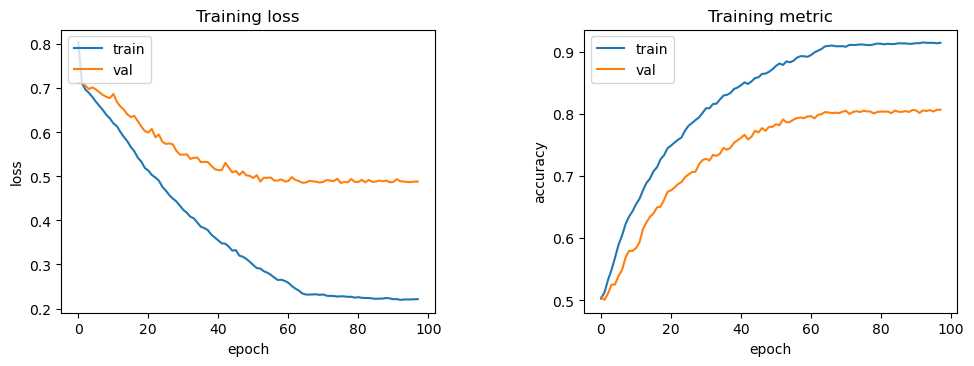

Epoch: 98 - Train Loss: 0.2213 / Validation Loss: 0.4881 / Train acc: 0.9148 / Val acc: 0.8069 / Learning Rate : 0.0000:   0%|          | 98/1000000 [06:19<1074:57:48,  3.87s/it]


Starting training for model B


Epoch: 49 - Train Loss: 0.1835 / Validation Loss: 0.4116 / Train acc: 0.9312 / Val acc: 0.8400 / Learning Rate : 0.0000:   0%|          | 49/1000000 [03:07<1062:51:16,  3.83s/it]

Training has converged after 49 epochs (lr < 1e-06)


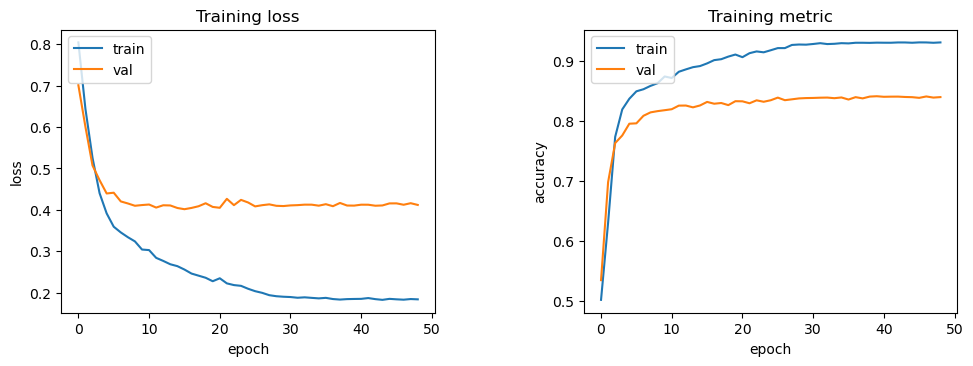

Epoch: 49 - Train Loss: 0.1835 / Validation Loss: 0.4116 / Train acc: 0.9312 / Val acc: 0.8400 / Learning Rate : 0.0000:   0%|          | 49/1000000 [03:07<1065:16:29,  3.84s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.99827548693837
fusion successful
fusion successfu

Epoch: 135 - Train Loss: 0.2204 / Validation Loss: 0.4384 / Train acc: 0.9237 / Val acc: 0.8016 / Learning Rate : 0.0000:   0%|          | 135/1000000 [08:04<994:10:49,  3.58s/it] 

Training has converged after 135 epochs (lr < 1e-06)


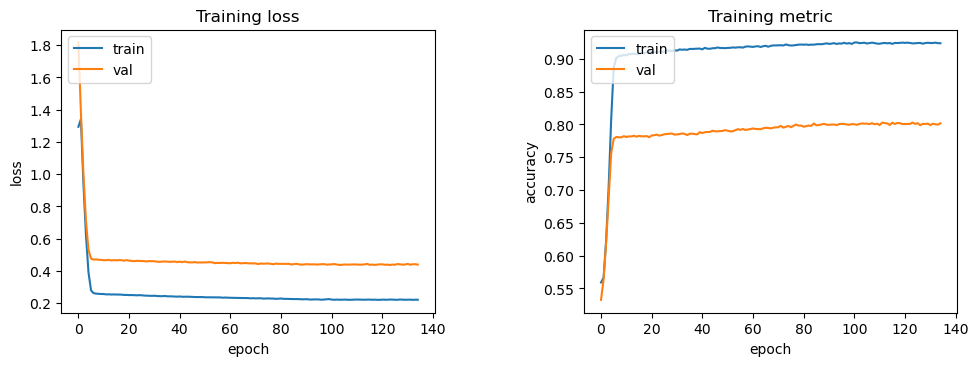

Epoch: 135 - Train Loss: 0.2204 / Validation Loss: 0.4384 / Train acc: 0.9237 / Val acc: 0.8016 / Learning Rate : 0.0000:   0%|          | 135/1000000 [08:04<997:05:48,  3.59s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 195 - Train Loss: 0.2320 / Validation Loss: 0.4509 / Train acc: 0.9185 / Val acc: 0.7935 / Learning Rate : 0.0000:   0%|          | 195/1000000 [06:41<570:54:19,  2.06s/it]

Training has converged after 195 epochs (lr < 1e-06)


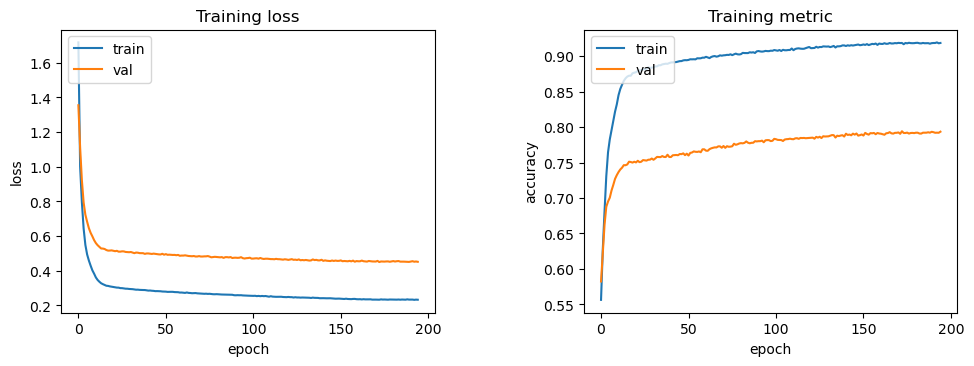

Epoch: 195 - Train Loss: 0.2320 / Validation Loss: 0.4509 / Train acc: 0.9185 / Val acc: 0.7935 / Learning Rate : 0.0000:   0%|          | 195/1000000 [06:41<571:30:49,  2.06s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 257 - Train Loss: 0.2266 / Validation Loss: 0.4513 / Train acc: 0.9202 / Val acc: 0.7948 / Learning Rate : 0.0000:   0%|          | 257/1000000 [08:47<559:59:31,  2.02s/it]

Training has converged after 257 epochs (lr < 1e-06)


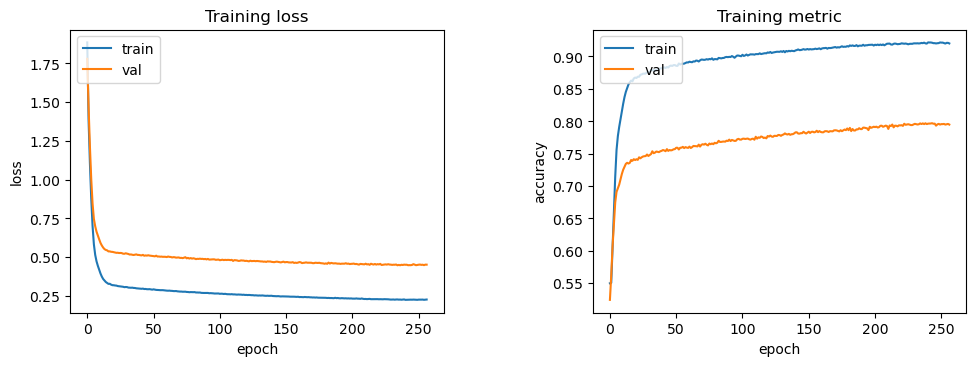

Epoch: 257 - Train Loss: 0.2266 / Validation Loss: 0.4513 / Train acc: 0.9202 / Val acc: 0.7948 / Learning Rate : 0.0000:   0%|          | 257/1000000 [08:47<570:00:50,  2.05s/it]


OT_post (method 1) loss: 0.4505644515156746 - accuracy: 0.793008850392512 - f1: 0.7919769883155823
OT_post (method 2) loss: 0.4469241450230281 - accuracy: 0.7961012983091786 - f1: 0.7951929569244385
vanilla_post loss: 0.43878041207790375 - accuracy: 0.8014488035929951 - f1: 0.8006094098091125
Fold 2/5
Vocabulary Size :  23054


100%|██████████| 5909/5909 [00:00<00:00, 12818.17it/s]


Positive labels ratio (train set): 0.5059022635921303
Positive labels ratio (test set): 0.4902690810627856
Dataset initializing done
Starting training for model A


Epoch: 100 - Train Loss: 0.1665 / Validation Loss: 0.4946 / Train acc: 0.9400 / Val acc: 0.8145 / Learning Rate : 0.0000:   0%|          | 100/1000000 [06:13<1036:16:40,  3.73s/it]

Training has converged after 100 epochs (lr < 1e-06)


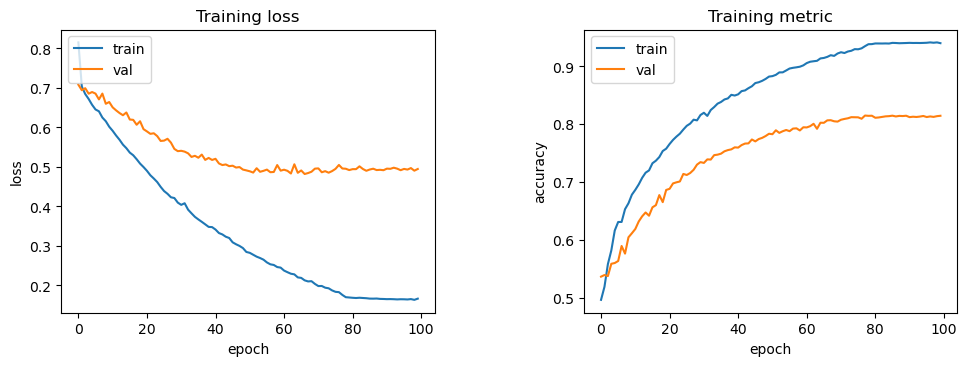

Epoch: 100 - Train Loss: 0.1665 / Validation Loss: 0.4946 / Train acc: 0.9400 / Val acc: 0.8145 / Learning Rate : 0.0000:   0%|          | 100/1000000 [06:13<1036:50:31,  3.73s/it]


Starting training for model B


Epoch: 44 - Train Loss: 0.1652 / Validation Loss: 0.3955 / Train acc: 0.9402 / Val acc: 0.8483 / Learning Rate : 0.0000:   0%|          | 44/1000000 [02:44<1036:50:22,  3.73s/it]

Training has converged after 44 epochs (lr < 1e-06)


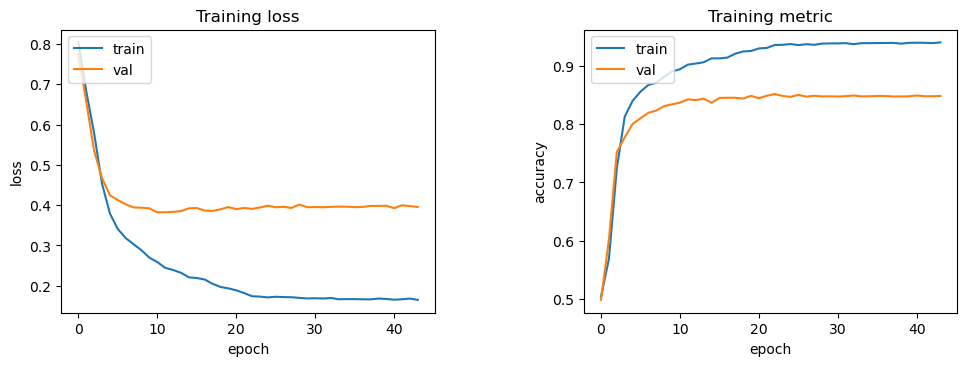

Epoch: 44 - Train Loss: 0.1652 / Validation Loss: 0.3955 / Train acc: 0.9402 / Val acc: 0.8483 / Learning Rate : 0.0000:   0%|          | 44/1000000 [02:44<1037:19:13,  3.73s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.003547029672240687
fusion successful
fusion succe

Epoch: 181 - Train Loss: 0.1901 / Validation Loss: 0.4276 / Train acc: 0.9374 / Val acc: 0.8188 / Learning Rate : 0.0000:   0%|          | 181/1000000 [11:11<1054:53:38,  3.80s/it]

Training has converged after 181 epochs (lr < 1e-06)


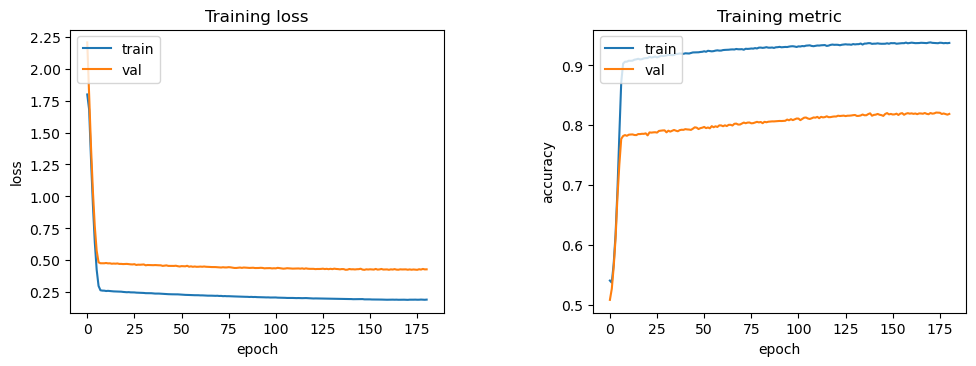

Epoch: 181 - Train Loss: 0.1901 / Validation Loss: 0.4276 / Train acc: 0.9374 / Val acc: 0.8188 / Learning Rate : 0.0000:   0%|          | 181/1000000 [11:12<1031:09:07,  3.71s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 213 - Train Loss: 0.2168 / Validation Loss: 0.3957 / Train acc: 0.9309 / Val acc: 0.8234 / Learning Rate : 0.0000:   0%|          | 213/1000000 [07:39<592:28:32,  2.13s/it]

Training has converged after 213 epochs (lr < 1e-06)


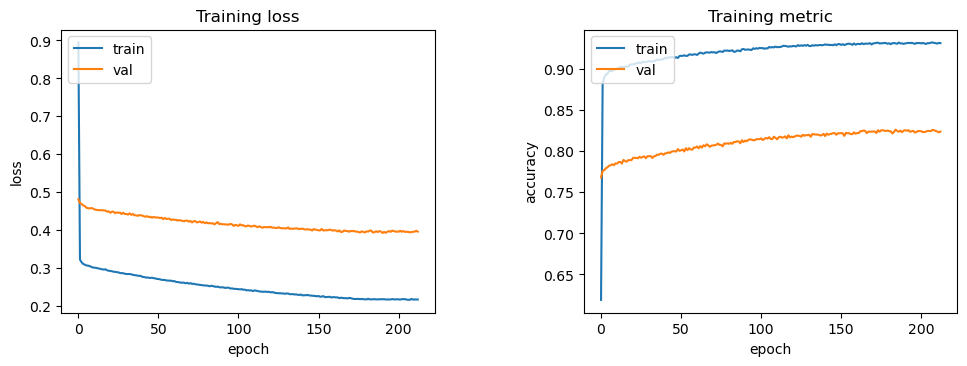

Epoch: 213 - Train Loss: 0.2168 / Validation Loss: 0.3957 / Train acc: 0.9309 / Val acc: 0.8234 / Learning Rate : 0.0000:   0%|          | 213/1000000 [07:39<599:07:28,  2.16s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 264 - Train Loss: 0.2012 / Validation Loss: 0.3859 / Train acc: 0.9367 / Val acc: 0.8353 / Learning Rate : 0.0000:   0%|          | 264/1000000 [09:27<597:33:46,  2.15s/it]

Training has converged after 264 epochs (lr < 1e-06)


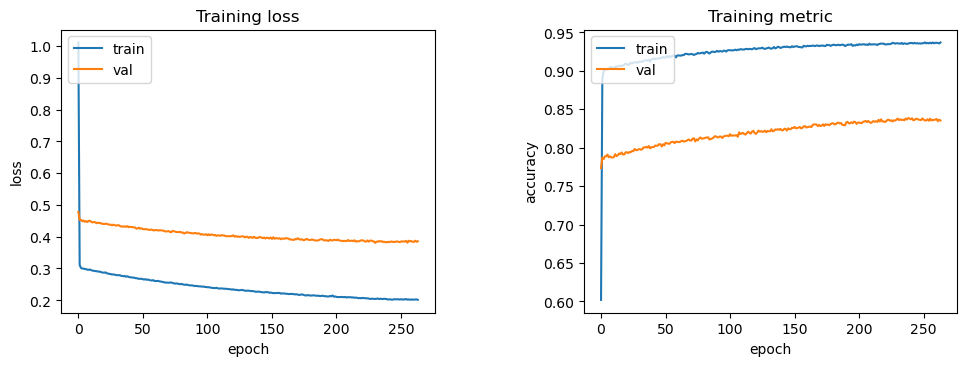

Epoch: 264 - Train Loss: 0.2012 / Validation Loss: 0.3859 / Train acc: 0.9367 / Val acc: 0.8353 / Learning Rate : 0.0000:   0%|          | 264/1000000 [09:27<596:52:53,  2.15s/it]


OT_post (method 1) loss: 0.39664627114931744 - accuracy: 0.8258028730445247 - f1: 0.8261973857879639
OT_post (method 2) loss: 0.38816937804222107 - accuracy: 0.8354550945773165 - f1: 0.8365205526351929
vanilla_post loss: 0.42897868653138477 - accuracy: 0.8197560591531287 - f1: 0.8197664618492126
Fold 3/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 21967.12it/s]


Positive labels ratio (train set): 0.5016289401311614
Positive labels ratio (test set): 0.5073616517177187
Dataset initializing done
Starting training for model A


Epoch: 100 - Train Loss: 0.1623 / Validation Loss: 0.5230 / Train acc: 0.9414 / Val acc: 0.8079 / Learning Rate : 0.0000:   0%|          | 100/1000000 [06:24<1035:43:20,  3.73s/it]

Training has converged after 100 epochs (lr < 1e-06)


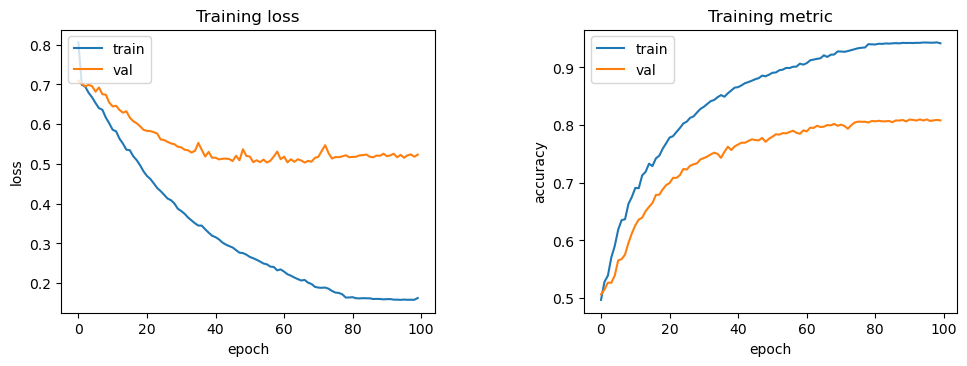

Epoch: 100 - Train Loss: 0.1623 / Validation Loss: 0.5230 / Train acc: 0.9414 / Val acc: 0.8079 / Learning Rate : 0.0000:   0%|          | 100/1000000 [06:25<1069:41:52,  3.85s/it]


Starting training for model B


Epoch: 45 - Train Loss: 0.1534 / Validation Loss: 0.4062 / Train acc: 0.9453 / Val acc: 0.8397 / Learning Rate : 0.0000:   0%|          | 45/1000000 [02:48<1036:31:51,  3.73s/it]

Training has converged after 45 epochs (lr < 1e-06)


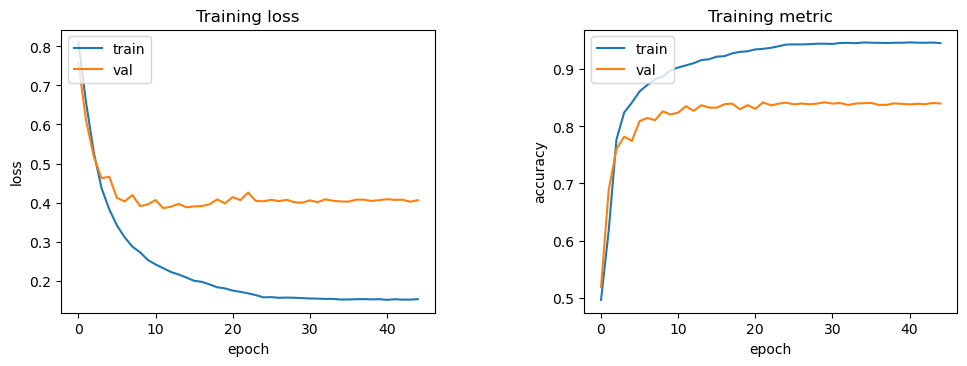

Epoch: 45 - Train Loss: 0.1534 / Validation Loss: 0.4062 / Train acc: 0.9453 / Val acc: 0.8397 / Learning Rate : 0.0000:   0%|          | 45/1000000 [02:48<1040:12:25,  3.74s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.0006570771408273915
fusion successful
fusion succ

Epoch: 148 - Train Loss: 0.1827 / Validation Loss: 0.4497 / Train acc: 0.9399 / Val acc: 0.8020 / Learning Rate : 0.0000:   0%|          | 148/1000000 [08:50<993:51:13,  3.58s/it] 

Training has converged after 148 epochs (lr < 1e-06)


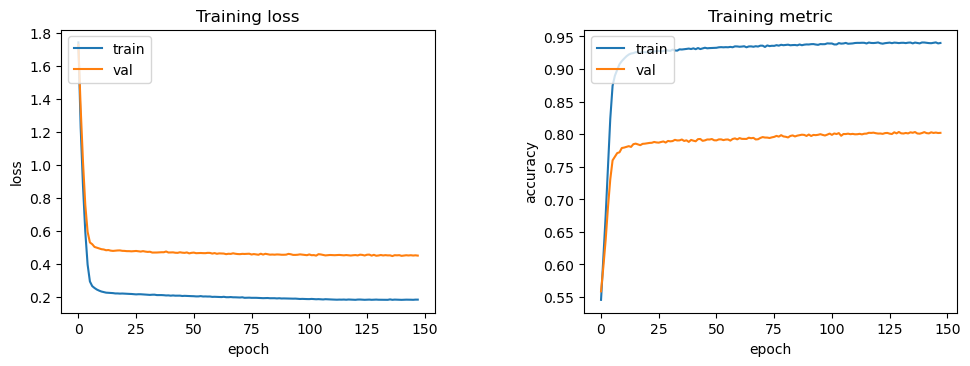

Epoch: 148 - Train Loss: 0.1827 / Validation Loss: 0.4497 / Train acc: 0.9399 / Val acc: 0.8020 / Learning Rate : 0.0000:   0%|          | 148/1000000 [08:50<995:53:04,  3.59s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 162 - Train Loss: 0.2188 / Validation Loss: 0.4237 / Train acc: 0.9354 / Val acc: 0.8040 / Learning Rate : 0.0000:   0%|          | 162/1000000 [05:29<562:33:02,  2.03s/it]

Training has converged after 162 epochs (lr < 1e-06)


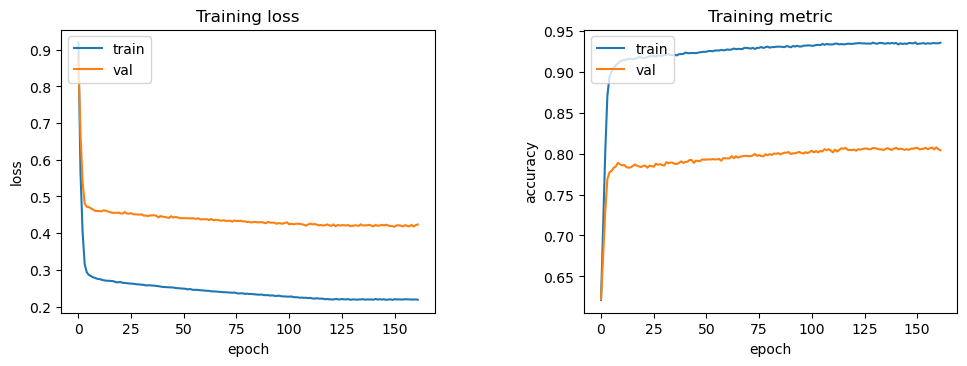

Epoch: 162 - Train Loss: 0.2188 / Validation Loss: 0.4237 / Train acc: 0.9354 / Val acc: 0.8040 / Learning Rate : 0.0000:   0%|          | 162/1000000 [05:29<564:46:19,  2.03s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 178 - Train Loss: 0.2072 / Validation Loss: 0.4129 / Train acc: 0.9364 / Val acc: 0.8132 / Learning Rate : 0.0000:   0%|          | 178/1000000 [06:01<561:55:42,  2.02s/it]

Training has converged after 178 epochs (lr < 1e-06)


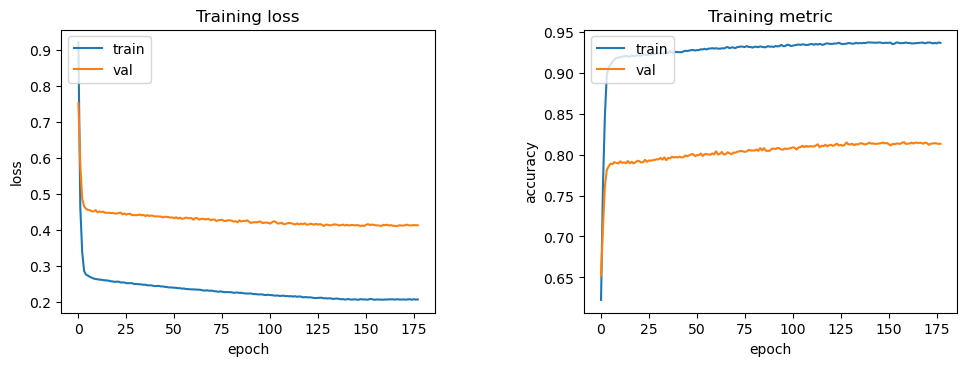

Epoch: 178 - Train Loss: 0.2072 / Validation Loss: 0.4129 / Train acc: 0.9364 / Val acc: 0.8132 / Learning Rate : 0.0000:   0%|          | 178/1000000 [06:01<564:34:33,  2.03s/it]


OT_post (method 1) loss: 0.4214775785803795 - accuracy: 0.8061828980520458 - f1: 0.8062278032302856
OT_post (method 2) loss: 0.4117627814412117 - accuracy: 0.8148879362214199 - f1: 0.813843309879303
vanilla_post loss: 0.4592398429910342 - accuracy: 0.8024147299939832 - f1: 0.8021661043167114
Fold 4/5
Vocabulary Size :  23075


100%|██████████| 5909/5909 [00:00<00:00, 24069.80it/s]


Positive labels ratio (train set): 0.5009519779987307
Positive labels ratio (test set): 0.5100693856828566
Dataset initializing done
Starting training for model A


Epoch: 90 - Train Loss: 0.1965 / Validation Loss: 0.5094 / Train acc: 0.9263 / Val acc: 0.8036 / Learning Rate : 0.0000:   0%|          | 90/1000000 [05:51<1060:08:57,  3.82s/it]

Training has converged after 90 epochs (lr < 1e-06)


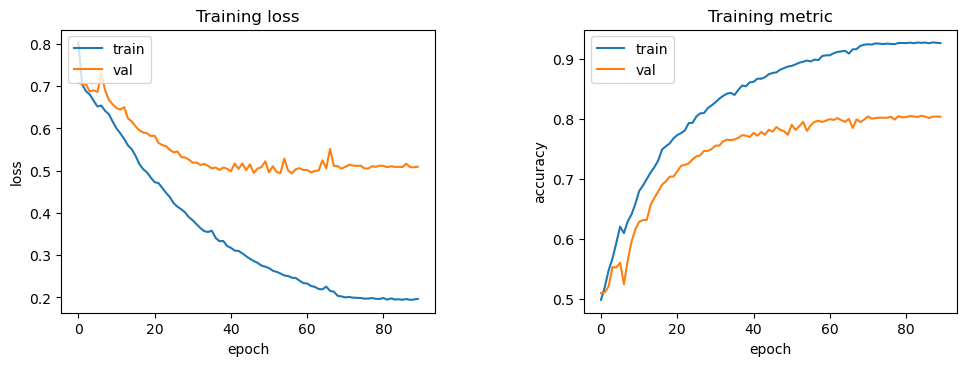

Epoch: 90 - Train Loss: 0.1965 / Validation Loss: 0.5094 / Train acc: 0.9263 / Val acc: 0.8036 / Learning Rate : 0.0000:   0%|          | 90/1000000 [05:52<1086:47:55,  3.91s/it]


Starting training for model B


Epoch: 55 - Train Loss: 0.1531 / Validation Loss: 0.4503 / Train acc: 0.9459 / Val acc: 0.8248 / Learning Rate : 0.0000:   0%|          | 55/1000000 [03:30<1057:52:43,  3.81s/it]

Training has converged after 55 epochs (lr < 1e-06)


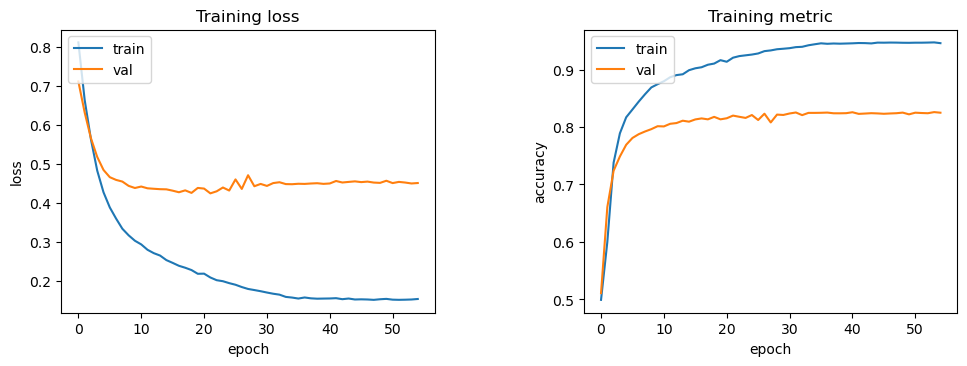

Epoch: 55 - Train Loss: 0.1531 / Validation Loss: 0.4503 / Train acc: 0.9459 / Val acc: 0.8248 / Learning Rate : 0.0000:   0%|          | 55/1000000 [03:30<1061:57:27,  3.82s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.012848810970203272
fusion successful
fusion succe

Epoch: 194 - Train Loss: 0.2153 / Validation Loss: 0.4887 / Train acc: 0.9204 / Val acc: 0.7838 / Learning Rate : 0.0000:   0%|          | 194/1000000 [11:50<1018:18:26,  3.67s/it]

Training has converged after 194 epochs (lr < 1e-06)


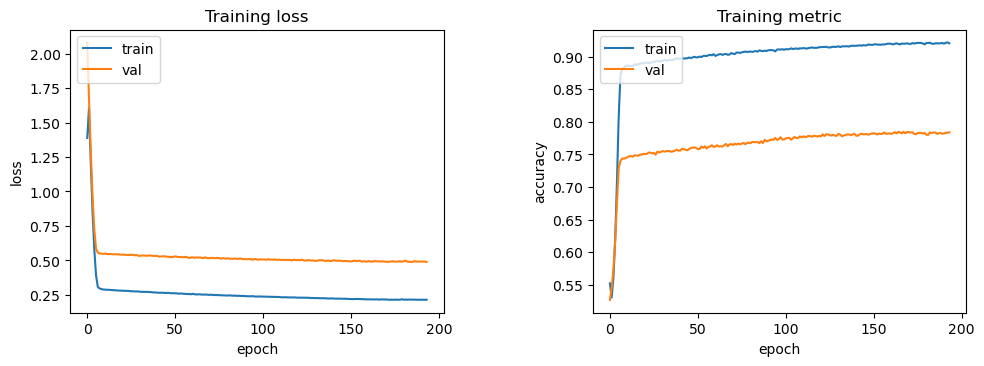

Epoch: 194 - Train Loss: 0.2153 / Validation Loss: 0.4887 / Train acc: 0.9204 / Val acc: 0.7838 / Learning Rate : 0.0000:   0%|          | 194/1000000 [11:50<1016:51:58,  3.66s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 338 - Train Loss: 0.2264 / Validation Loss: 0.4712 / Train acc: 0.9210 / Val acc: 0.7849 / Learning Rate : 0.0000:   0%|          | 338/1000000 [11:31<562:31:58,  2.03s/it]

Training has converged after 338 epochs (lr < 1e-06)


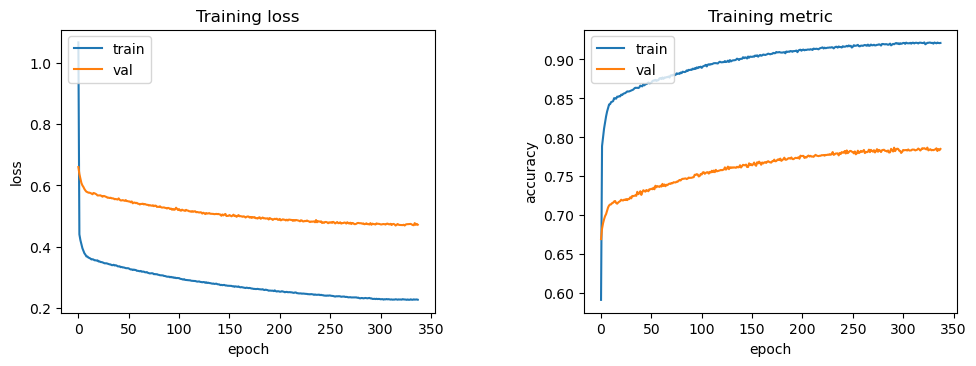

Epoch: 338 - Train Loss: 0.2264 / Validation Loss: 0.4712 / Train acc: 0.9210 / Val acc: 0.7849 / Learning Rate : 0.0000:   0%|          | 338/1000000 [11:31<568:00:38,  2.05s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 313 - Train Loss: 0.2337 / Validation Loss: 0.4841 / Train acc: 0.9171 / Val acc: 0.7791 / Learning Rate : 0.0000:   0%|          | 313/1000000 [10:46<576:01:18,  2.07s/it] 

Training has converged after 313 epochs (lr < 1e-06)


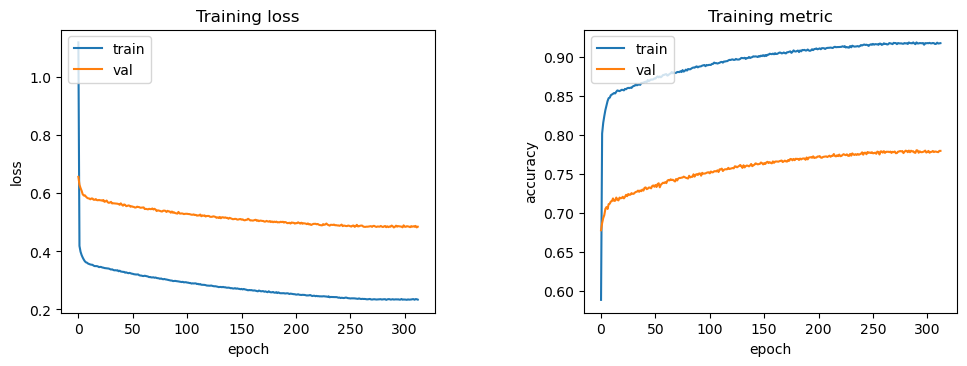

Epoch: 313 - Train Loss: 0.2337 / Validation Loss: 0.4841 / Train acc: 0.9171 / Val acc: 0.7791 / Learning Rate : 0.0000:   0%|          | 313/1000000 [10:46<573:54:16,  2.07s/it]


OT_post (method 1) loss: 0.46915346135695773 - accuracy: 0.7872780112439832 - f1: 0.7864274978637695
OT_post (method 2) loss: 0.483800229926904 - accuracy: 0.7787751015342961 - f1: 0.7783042788505554
vanilla_post loss: 0.4944813499848048 - accuracy: 0.7838553418321299 - f1: 0.7847351431846619
Fold 5/5
Vocabulary Size :  23043


100%|██████████| 5909/5909 [00:00<00:00, 22468.23it/s]


Positive labels ratio (train set): 0.503448275862069
Positive labels ratio (test set): 0.5000846166864106
Dataset initializing done
Starting training for model A


Epoch: 97 - Train Loss: 0.2066 / Validation Loss: 0.4926 / Train acc: 0.9229 / Val acc: 0.8056 / Learning Rate : 0.0000:   0%|          | 97/1000000 [06:13<1097:57:43,  3.95s/it]

Training has converged after 97 epochs (lr < 1e-06)


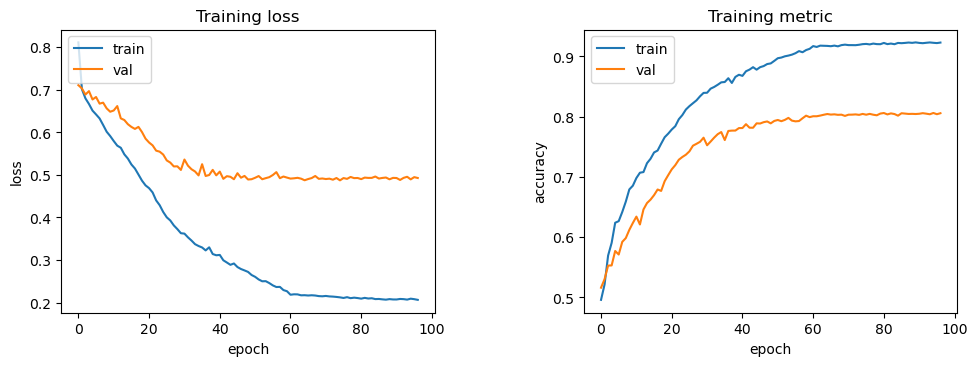

Epoch: 97 - Train Loss: 0.2066 / Validation Loss: 0.4926 / Train acc: 0.9229 / Val acc: 0.8056 / Learning Rate : 0.0000:   0%|          | 97/1000000 [06:14<1071:31:10,  3.86s/it]


Starting training for model B


Epoch: 54 - Train Loss: 0.1769 / Validation Loss: 0.4362 / Train acc: 0.9356 / Val acc: 0.8265 / Learning Rate : 0.0000:   0%|          | 54/1000000 [03:29<1061:41:03,  3.82s/it]

Training has converged after 54 epochs (lr < 1e-06)


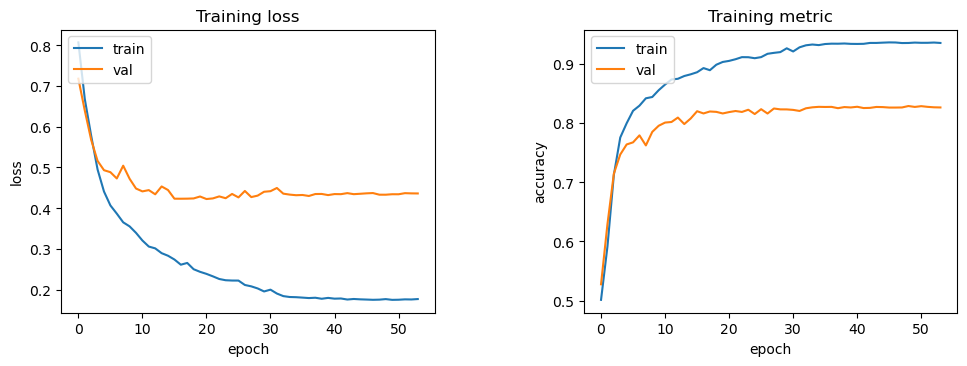

Epoch: 54 - Train Loss: 0.1769 / Validation Loss: 0.4362 / Train acc: 0.9356 / Val acc: 0.8265 / Learning Rate : 0.0000:   0%|          | 54/1000000 [03:29<1076:53:33,  3.88s/it]


fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
fusion successful
Best fusion weight (method 1): 0.9987028415438397
fusion successful
fusion success

Epoch: 190 - Train Loss: 0.2226 / Validation Loss: 0.4667 / Train acc: 0.9194 / Val acc: 0.7942 / Learning Rate : 0.0000:   0%|          | 190/1000000 [11:40<1030:50:26,  3.71s/it]

Training has converged after 190 epochs (lr < 1e-06)


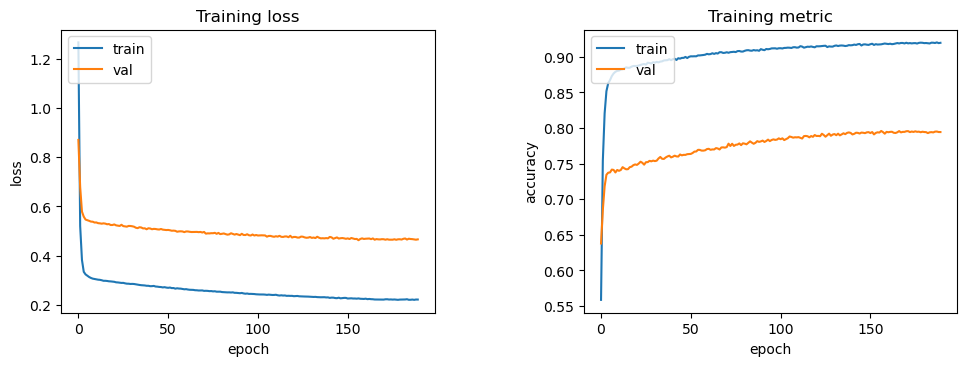

Epoch: 190 - Train Loss: 0.2226 / Validation Loss: 0.4667 / Train acc: 0.9194 / Val acc: 0.7942 / Learning Rate : 0.0000:   0%|          | 190/1000000 [11:40<1023:29:59,  3.69s/it]


Starting retraining for model OT fusion (method 1)


Epoch: 329 - Train Loss: 0.2293 / Validation Loss: 0.4673 / Train acc: 0.9147 / Val acc: 0.7933 / Learning Rate : 0.0000:   0%|          | 329/1000000 [11:23<574:46:47,  2.07s/it]

Training has converged after 329 epochs (lr < 1e-06)


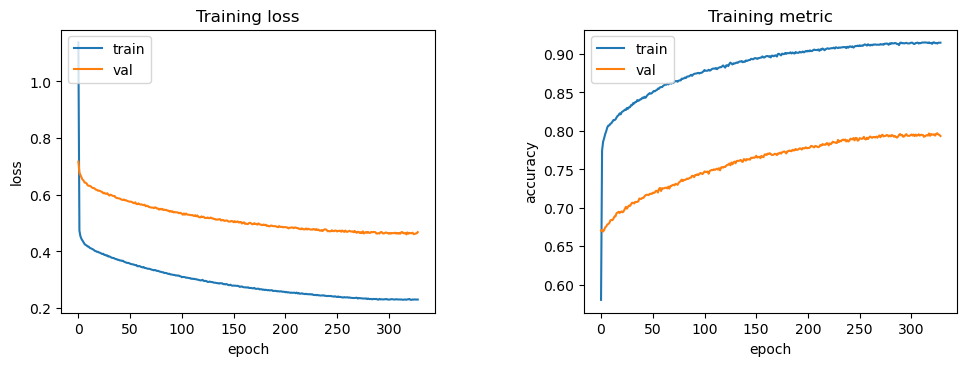

Epoch: 329 - Train Loss: 0.2293 / Validation Loss: 0.4673 / Train acc: 0.9147 / Val acc: 0.7933 / Learning Rate : 0.0000:   0%|          | 329/1000000 [11:23<576:57:36,  2.08s/it]


Starting retraining for model OT fusion (method 2)


Epoch: 276 - Train Loss: 0.2282 / Validation Loss: 0.4584 / Train acc: 0.9166 / Val acc: 0.7956 / Learning Rate : 0.0000:   0%|          | 276/1000000 [09:34<574:58:01,  2.07s/it]

Training has converged after 276 epochs (lr < 1e-06)


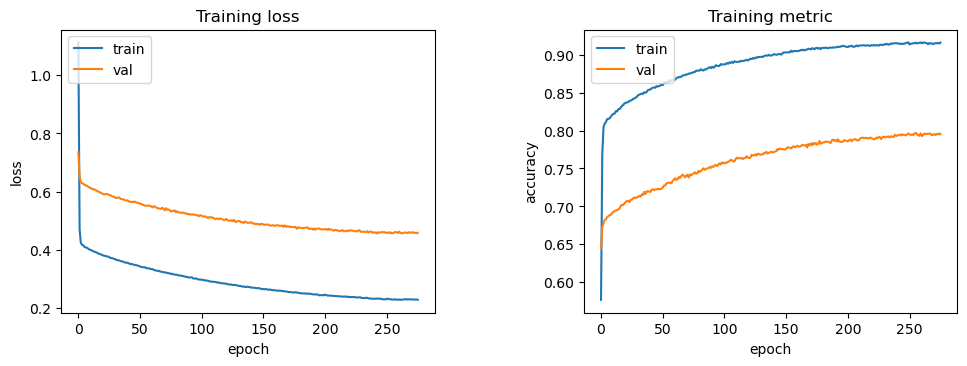

Epoch: 276 - Train Loss: 0.2282 / Validation Loss: 0.4584 / Train acc: 0.9166 / Val acc: 0.7956 / Learning Rate : 0.0000:   0%|          | 276/1000000 [09:34<578:31:50,  2.08s/it]


OT_post (method 1) loss: 0.4626084392269452 - accuracy: 0.7959043133273165 - f1: 0.7953968644142151
OT_post (method 2) loss: 0.45829447358846664 - accuracy: 0.7950264647262335 - f1: 0.7950583696365356
vanilla_post loss: 0.4760804995894432 - accuracy: 0.7913963786101084 - f1: 0.790996789932251
CPU times: total: 3h 17min 38s
Wall time: 3h 8min 21s


In [99]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for i in range(FOLDS):
        print(f'Fold {i + 1}/{FOLDS}')

        # get training, test set
        train_set, test_set = datasets.pop()

        # build generators
        train_iterator, test_iterator, voc_size, pad_idx, embedding = build_generators(train_set, test_set, device, batch_size=512)

        # train parent models
        train_parent = lambda x: train_early_stopping(model_name=x,
                                                      train_iter=train_iterator,
                                                      valid_iter=test_iterator,
                                                      embedding=embedding,
                                                      pad_idx=pad_idx,
                                                      voc_size=voc_size,
                                                      device=device,
                                                      lr=LEARNING_RATE,
                                                      save=False)
        print('Starting training for model A')
        modelA = train_parent('A')
        print('Starting training for model B')
        modelB = train_parent('B')

        # model fusion
        # 1) vanilla
        model_fusion_vanilla = vanilla_fusion(modelA=modelA, modelB=modelB, pad_idx=pad_idx, voc_size=voc_size, embedding=embedding, device=device)
        # 2) optimal transport
        N_TRIALS = 50
        variations = ['multilayer', 'multihead-multilayer']
        # 2.1) method 1
        variation = variations[0]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 1):', best_weighting_factor)
        model_fusion_1 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)
        # 2.2) method 2
        variation = variations[1]
        study = optuna.create_study()
        study.optimize(weighted_fusion(modelA, modelB, train_iterator, test_iterator, embedding, pad_idx, voc_size, device, variation=variation), n_trials=N_TRIALS)
        best_weighting_factor = study.best_params['weighting_factor']
        print('Best fusion weight (method 2):', best_weighting_factor)
        model_fusion_2 = ot_fusion(modelA, modelB, train_iterator, embedding, pad_idx, voc_size, device, fusion_ratio=best_weighting_factor, variation=variation)

        # evaluate
        # ensure all models on same device
        model_to_cpu = lambda x: x.to(device)
        modelA = model_to_cpu(modelA)
        modelB = model_to_cpu(modelB)
        model_random = new_model(embedding, pad_idx, voc_size, device, n_layers=N_LAYERS)
        model_fusion_1 = model_to_cpu(model_fusion_1)
        model_fusion_2 = model_to_cpu(model_fusion_2)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('A', 'B', 'random', 'OT_pre (method 1)', 'OT_pre (method 2)', 'vanilla_pre'),
                               (modelA, modelB, model_random, model_fusion_1, model_fusion_2, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

        # retraining
        retrain = lambda x: train(model=x,
                                  iterator=train_iterator,
                                  valid_iter=test_iterator,
                                  optimizer=torch.optim.SGD(x.parameters(), lr=LEARNING_RATE),
                                  criterion=nn.CrossEntropyLoss(),
                                  epoch=EPOCHS,
                                  clip=1,
                                  device=device)
        # 1) vanilla
        # train with early stopping
        print('Starting retraining for model vanilla fusion')
        retrain(model_fusion_vanilla)

        # 2) optimal transport
        # train with early stopping
        print('Starting retraining for model OT fusion (method 1)')
        retrain(model_fusion_1)
        print('Starting retraining for model OT fusion (method 2)')
        retrain(model_fusion_2)

        # evaluate
        # ensure all models on same device
        model_fusion_1 = model_to_cpu(model_fusion_1)
        model_fusion_2 = model_to_cpu(model_fusion_2)
        model_fusion_vanilla = model_to_cpu(model_fusion_vanilla)

        # test models
        for name, model in zip(('OT_post (method 1)', 'OT_post (method 2)', 'vanilla_post'), (model_fusion_1, model_fusion_2, model_fusion_vanilla)):
            loss, acc, f1 = validation(model, test_iterator, nn.CrossEntropyLoss(), device) # (loss, accuracy, f1)

            # put into cpu
            to_cpu = lambda x: x.to('cpu') if isinstance(x, torch.Tensor) else x
            loss = to_cpu(loss)
            acc = to_cpu(acc)
            f1 = to_cpu(f1)

            print(name, f'loss: {loss} - accuracy: {acc} - f1: {f1}')
            scores['loss'][name].append(loss), scores['accuracy'][name].append(acc), scores['f1'][name].append(f1)

### Export as LaTeX

In [103]:
model_names_latex = ['Model A', 'Model B', 'Vanilla', 'Vanilla (retraining)', 'Optimal transport (method 1)', 'Optimal transport (method 1 - retraining)',
                     'Optimal transport (method 2)', 'Optimal transport (method 2 - retraining)', 'Untrained model (baseline)']

In [104]:
latex = scores_to_latex(scores, model_names_latex)

                                                   loss  \
A                   [0.439, 0.462, 0.506, 0.468, 0.467]   
B                    [0.414, 0.398, 0.406, 0.451, 0.43]   
vanilla_pre         [2.137, 2.555, 1.453, 2.196, 0.989]   
vanilla_post        [0.439, 0.429, 0.459, 0.494, 0.476]   
OT_pre (method 1)    [1.617, 0.509, 0.81, 0.665, 0.724]   
OT_post (method 1)  [0.451, 0.397, 0.421, 0.469, 0.463]   
OT_pre (method 2)    [2.071, 0.57, 0.689, 0.647, 0.796]   
OT_post (method 2)  [0.447, 0.388, 0.412, 0.484, 0.458]   
random              [0.761, 0.734, 0.787, 0.809, 0.723]   

                                               accuracy  \
A                    [0.825, 0.83, 0.813, 0.821, 0.821]   
B                    [0.841, 0.848, 0.84, 0.826, 0.828]   
vanilla_pre         [0.515, 0.498, 0.586, 0.524, 0.621]   
vanilla_post         [0.801, 0.82, 0.802, 0.784, 0.791]   
OT_pre (method 1)    [0.542, 0.747, 0.64, 0.667, 0.666]   
OT_post (method 1)  [0.793, 0.826, 0.806, 0.787, 0.796]

C:\Users\jjung\AppData\Local\Temp\ipykernel_6736\2326405879.py:1010: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(index=True,


In [102]:
# save as latex (in text format) (optional)
with open('./Output/scores_different_seeds_multilayer.txt','w') as dat:
    dat.write(str(latex))